# Compare Hubway station locations with census data

In [2]:
%matplotlib inline

In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import pandas as pd
from pysal.esda.mapclassify import Natural_Breaks as nb
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch

Import Hubway stations and determine bounding box for map.

In [12]:
stations_fn = 'hubway-data/Hubway_Stations_2011_2016.csv'
stations = pd.read_csv(stations_fn,
                       names=['station', 'id', 'lat', 'lon', 'muni', 'docks'],
                       header=0,
                       index_col='id')
stations.head()

,station,lat,lon,muni,docks
id,,,,,
A32000,Fan Pier,42.353287,-71.044389,Boston,15
A32001,Union Square - Brighton Ave. at Cambridge St.,42.353334,-71.137313,Boston,15
A32002,Agganis Arena - 925 Comm Ave.,42.351246,-71.115639,Boston,19
A32003,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,Boston,11
A32004,Longwood Ave / Binney St,42.338629,-71.106500,Boston,15


In [88]:
pad = 0.01

llclat = stations.lat.min() - pad
llclon = stations.lon.min() - pad
urclat = stations.lat.max() + pad
urclon = stations.lon.max() + pad
print(llclat, llclon, urclat, urclon)

(42.293469000000002, -71.17636693, 42.414490000000001, -70.996212229999998)


Set up map with basemap.

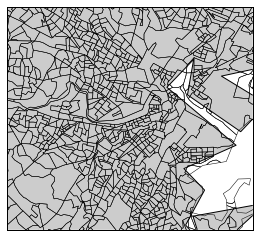

In [89]:
hub_map = Basemap(
    projection='merc',
    llcrnrlon=llclon,
    llcrnrlat=llclat,
    urcrnrlon=urclon,
    urcrnrlat=urclat,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

# census block shapefiles
hub_map.readshapefile(
    'census-data/cb_2015_25_bg_500k',
    'census',
    color='black',
    zorder=2)

hub_map.drawcoastlines()
hub_map.fillcontinents()
hub_map.drawmapboundary()

In [90]:
df_map = pd.DataFrame({'poly': [Polygon(xy) for xy in hub_map.census],
                       'geoid': [tract['GEOID'] for tract in hub_map.census_info]}).set_index('geoid')
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map.index = df_map.index.astype(np.int64)
df_map.head()

,poly,area_m
geoid,,
250199501002,POLYGON ((117145.0878338043 -149068.3067877134...,6.752867e+06
250214177021,POLYGON ((19973.70509436856 -4040.713852831163...,6.025576e+05
250173661005,"POLYGON ((-22763.9336420744 5353.302288163453,...",2.964533e+06
250138120012,POLYGON ((-160610.4401748063 -12922.8418411407...,2.484442e+05
250250604001,"POLYGON ((14688.61271961667 6315.810444090515,...",1.398777e+05


In [91]:
corners = [(llclat, llclon), (llclat, urclon), (urclat, urclon), (urclat, llclon)]
corners_map = [hub_map(lon, lat) for (lat, lon) in corners]
bbox  = Polygon(corners_map)

In [92]:
df_bounded = df_map[[bbox.intersects(x) for x in df_map['poly']]]
print(df_map.shape)
print(df_bounded.shape)
df_bounded.head()

(5050, 2)
(808, 2)


,poly,area_m
geoid,,
250250604001,"POLYGON ((14688.61271961667 6315.810444090515,...",139877.672090
250250102031,"POLYGON ((8991.32094589241 7927.429900289513, ...",115580.673079
250250008024,"POLYGON ((5063.473206660022 9859.538815372624,...",613127.180494
250250911001,"POLYGON ((13303.68056040066 3787.98790681269, ...",196488.324093
250173541002,"POLYGON ((5091.383120106118 12219.5012005195, ...",410196.232140


Load census block level data from American Community Survey on population and income.

In [93]:
income.dtypes

income    object
dtype: object

In [94]:
pop_fn = 'census-data/ACS_15_5YR_B01003_with_ann.csv'
population = pd.read_csv(pop_fn, skiprows=[0,1], usecols = [1,3],
                     names=['geoid', 'population'], index_col='geoid', na_values='-')

income_fn = 'census-data/ACS_15_5YR_B19013_with_ann.csv'
income = pd.read_csv(income_fn, skiprows=[0,1], usecols = [1,3],
                     names=['geoid', 'income'], index_col='geoid', na_values='-')

acs = pd.concat([population, income], axis=1)
acs.head()

,population,income
geoid,,
250173001001,1658,79844
250173001002,1519,88295
250173011011,1793,76875
250173011012,1016,69942
250173011013,1213,65000


Combine census data with polygons of each block.

In [140]:
df_combined = df_bounded.join(acs)
df_combined['popdens'] = df_combined['population']/df_combined['area_m']*1e3
print(df_combined.shape)
df_combined.head(10)

(808, 5)


,poly,area_m,population,income,popdens
geoid,,,,,
250173391004,"POLYGON ((6476.760058819727 19647.42300676182,...",1.049150e+06,1687.0,24836,1.607968
250173394001,"POLYGON ((5582.197295198372 18686.11700299382,...",5.433405e+05,671.0,67500,1.234953
250173394002,"POLYGON ((5622.116255066918 18164.08237731829,...",1.701105e+05,735.0,NaN,4.320722
250173394003,"POLYGON ((5692.16902586638 18308.06827313919, ...",2.023414e+05,972.0,86150,4.803762
250173394004,"POLYGON ((5169.997896226008 18043.14194538165,...",2.771354e+05,914.0,67037,3.298027
250173395001,"POLYGON ((5666.816594528695 17592.98002337478,...",1.022552e+06,3226.0,136563,3.154853
250173395002,"POLYGON ((6959.568202963154 18252.94370644353,...",6.301943e+05,1030.0,49815,1.634417
250173395004,"POLYGON ((6423.275324287936 18487.45126203727,...",2.749991e+05,962.0,83409,3.498193
250173396001,"POLYGON ((7003.378983431318 17611.65476525202,...",3.664908e+05,686.0,61635,1.871807


Check how many blocks are missing census data.

In [141]:
print(df_combined[df_combined['income'].isnull()].shape)
print(df_combined[df_combined['population'].isnull()].shape)

(123, 5)
(43, 5)


Use fancy "Jenks Natural Breaks" method to split up incomes. Except first have to deal with "250,000+" income rows. Call them 250000.

In [142]:
df_combined.loc[df_combined['income']=="250,000+", 'income'] = 250000

In [143]:
income_array = df_combined[df_combined['income'].notnull()].income.astype(int).values
# Calculate Jenks natural breaks for density
breaks = nb(
    income_array,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_combined[df_combined['income'].notnull()].index)
df_combined['jenks_bins'] = jb
df_combined.jenks_bins.fillna(-1, inplace=True)
breaks

                  Natural_Breaks                 
 
  Lower                Upper                Count
             x[i] <=  39258.000               145
 39258.000 < x[i] <=  64665.000               183
 64665.000 < x[i] <=  92679.000               167
 92679.000 < x[i] <= 136563.000               153
136563.000 < x[i] <= 250000.000                37

In [144]:
jenks_labels = ["<= %0.1f(%s block groups)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]
jenks_labels.insert(0, 'Missing income data (%s block groups)' % len(df_combined[df_combined['income'].isnull()]))
jenks_labels

['Missing income data (123 block groups)',
 '<= 39258.0(145 block groups)',
 '<= 64665.0(183 block groups)',
 '<= 92679.0(167 block groups)',
 '<= 136563.0(153 block groups)',
 '<= 250000.0(37 block groups)']

In [145]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

Prep station points for plot

In [146]:
station_points = pd.Series([Point(hub_map(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(stations['lon'], stations['lat'])])

Make plot, colored by income!

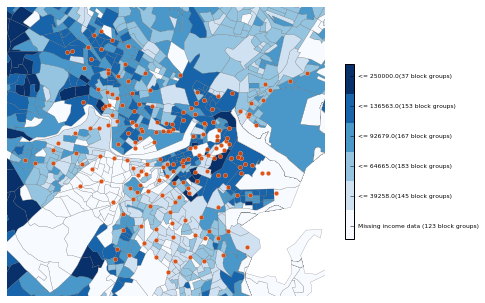

In [156]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
df_combined['patches'] = df_combined['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_combined['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_combined['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=6)

dev = hub_map.scatter(
    [geom.x for geom in station_points],
    [geom.y for geom in station_points],
    20, marker='o', lw=.25,
    facecolor='#dd4400', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Hubway stations', zorder=3)

plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.show()    

Repeat for population.

In [148]:
pop_array = df_combined[df_combined['popdens'].notnull()].popdens.values
# Calculate Jenks natural breaks for density
pop_breaks = nb(
    pop_array,
    initial=300,
    k=5)

In [149]:
# the notnull method lets us match indices when joining
jb_pop = pd.DataFrame({'pop_bins': pop_breaks.yb}, index=df_combined[df_combined['popdens'].notnull()].index)

In [150]:
df_combined = df_combined.join(jb_pop)
df_combined.pop_bins.fillna(-1, inplace=True)
pop_breaks

              Natural_Breaks             
 
Lower            Upper              Count
         x[i] <=  2.806               223
 2.806 < x[i] <=  5.363               251
 5.363 < x[i] <=  8.564               163
 8.564 < x[i] <= 15.535               100
15.535 < x[i] <= 36.827                28

In [151]:
df_combined.head()

,poly,area_m,population,income,popdens,jenks_bins,patches,pop_bins
geoid,,,,,,,,
250173391004,"POLYGON ((6476.760058819727 19647.42300676182,...",1.049150e+06,1687.0,24836,1.607968,0.0,"Poly((6476.76, 19647.4) ...)",0.0
250173394001,"POLYGON ((5582.197295198372 18686.11700299382,...",5.433405e+05,671.0,67500,1.234953,2.0,"Poly((5582.2, 18686.1) ...)",0.0
250173394002,"POLYGON ((5622.116255066918 18164.08237731829,...",1.701105e+05,735.0,NaN,4.320722,-1.0,"Poly((5622.12, 18164.1) ...)",1.0
250173394003,"POLYGON ((5692.16902586638 18308.06827313919, ...",2.023414e+05,972.0,86150,4.803762,2.0,"Poly((5692.17, 18308.1) ...)",1.0
250173394004,"POLYGON ((5169.997896226008 18043.14194538165,...",2.771354e+05,914.0,67037,3.298027,2.0,"Poly((5170, 18043.1) ...)",1.0


In [152]:
pop_labels = ["<= %0.1f(%s block groups)" % (b, c) for b, c in zip(
    pop_breaks.bins, pop_breaks.counts)]
pop_labels.insert(0, 'Missing population data (%s block groups)' % len(df_combined[df_combined['popdens'].isnull()]))
pop_labels

['Missing population data (43 block groups)',
 '<= 2.8(223 block groups)',
 '<= 5.4(251 block groups)',
 '<= 8.6(163 block groups)',
 '<= 15.5(100 block groups)',
 '<= 36.8(28 block groups)']

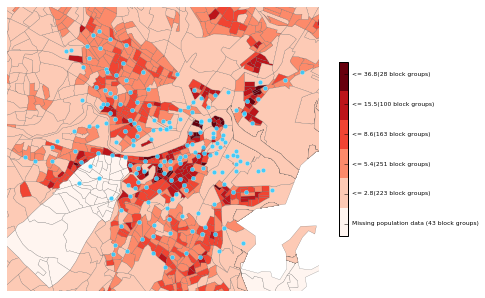

In [155]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Reds')
# draw wards with grey outlines
df_combined['patches'] = df_combined['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_combined['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_combined['pop_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(pop_labels), cmap=cmap, shrink=0.5, labels=pop_labels)
cb.ax.tick_params(labelsize=6)

dev = hub_map.scatter(
    [geom.x for geom in station_points],
    [geom.y for geom in station_points],
    20, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Hubway stations', zorder=3)

plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.show()    